## Data Preparation & Cleaning

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'online_retail_II.xlsx'

In [2]:
df_2009 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
print(df_2009.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [15]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df_2009.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [7]:
df_2009.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [254]:
# Data Cleaning for 2009-2010 Data
df = df_2009.copy()

# Remove rows with missing Customer ID or Description
df = df.dropna(subset=['Customer ID', 'Description'])

# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0 ) & (df['Price'] > 0)]
df['Invoice'] = df['Invoice'].astype(str)

# Remove canceled orders (Invoice starting with 'C')
df = df[~df['Invoice'].str.startswith('C')]

# Create Total Sales column
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove duplicate rows
df = df.drop_duplicates()

# Convert Customer ID to integer
df['Customer ID'] = df['Customer ID'].astype(int)

## Exploratory Data Analysis

### Cohort Analysis

In [145]:
# Group by Transaction
df = df.groupby(['Invoice', 'Customer ID', 'InvoiceDate', 'Country'], as_index=False).agg({'TotalSales': 'sum'})
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')
df['CohortIndex'] = (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month)

cohort_data = df.groupby(['CohortMonth', 'CohortIndex']).agg({'Customer ID': 'nunique'}).reset_index()
cohort_table = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')
cohort_size = cohort_table.iloc[:,0]
retention = cohort_table.divide(cohort_size, axis=0)
retention.style.format("{:.0%}")
retention

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,0.421990,0.495288,0.248168
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,0.302872,0.099217,NaN
2010-02,1.0,0.237968,0.224599,0.291444,0.245989,0.200535,0.192513,0.286096,0.254011,0.275401,0.072193,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.068027,NaN,NaN,NaN,NaN
2010-05,1.0,0.157480,0.169291,0.173228,0.177165,0.255906,0.212598,0.078740,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.174074,0.188889,0.203704,0.229630,0.285185,0.066667,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.155914,0.182796,0.295699,0.290323,0.102151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.203704,0.296296,0.320988,0.117284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Activity-Based Retention

In [146]:
df = df.groupby(['Invoice', 'Customer ID', 'InvoiceDate', 'Country'], as_index=False).agg({'TotalSales': 'sum'})
df = df.sort_values(['Customer ID', 'InvoiceDate'])

df['PrevInvoiceDate'] = df.groupby('Customer ID')['InvoiceDate'].shift(1)
df['DaysBetween'] = (df['InvoiceDate'] - df['PrevInvoiceDate']).dt.days
df

,Invoice,Customer ID,InvoiceDate,Country,TotalSales,PrevInvoiceDate,DaysBetween
1006,491725,12346,2009-12-14 08:34:00,United Kingdom,45.00,NaT,NaN
1017,491742,12346,2009-12-14 11:00:00,United Kingdom,22.50,2009-12-14 08:34:00,0.0
1019,491744,12346,2009-12-14 11:02:00,United Kingdom,22.50,2009-12-14 11:00:00,0.0
1361,492718,12346,2009-12-18 10:47:00,United Kingdom,22.50,2009-12-14 11:02:00,3.0
1363,492722,12346,2009-12-18 10:55:00,United Kingdom,1.00,2009-12-18 10:47:00,0.0
...,...,...,...,...,...,...,...
11572,519785,18286,2010-08-20 11:57:00,United Kingdom,833.48,2009-12-16 10:45:00,247.0
7197,508581,18287,2010-05-17 11:55:00,United Kingdom,1071.61,NaT,NaN
13022,523289,18287,2010-09-21 12:17:00,United Kingdom,862.00,2010-05-17 11:55:00,127.0
13023,523290,18287,2010-09-21 12:19:00,United Kingdom,30.60,2010-09-21 12:17:00,0.0


### Days between Purchases Histogram

Text(0.5, 1.0, 'Histogram of Days Between Purchases')

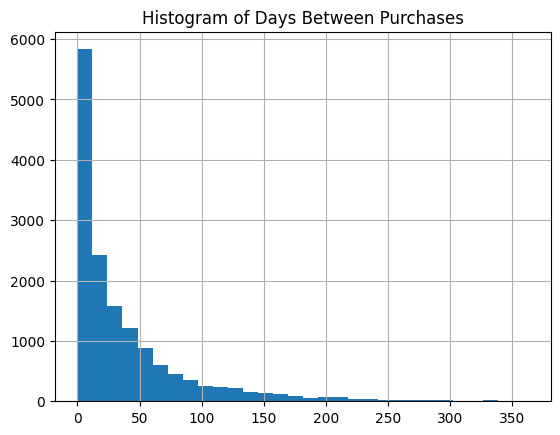

In [147]:
histogram = df['DaysBetween'].hist(bins=30)
histogram.set_title('Histogram of Days Between Purchases')

### Heatmap for Average Sales by Day of the Week and Hour of the Day

In [165]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

heatmap_data = df.pivot_table(index='DayOfWeek', columns='HourOfDay', values='TotalSales').fillna(0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)
heatmap_data

HourOfDay,7,8,9,10,11,12,13,14,15,16,17,18,19,20
DayOfWeek,,,,,,,,,,,,,,
Monday,1438.584000,561.284643,589.398439,470.913708,508.565216,438.787960,475.875175,399.281129,404.676031,739.607543,381.405063,546.764167,0.000000,0.000000
Tuesday,789.973333,529.000118,454.330795,512.068914,533.135215,419.942318,434.287312,450.666385,555.735786,566.145133,387.206241,374.387941,490.129000,330.900000
Wednesday,1127.883333,464.879255,507.720489,546.438005,472.186337,459.749898,377.770279,406.553644,352.712722,438.859283,414.443947,0.000000,0.000000,0.000000
Thursday,640.713333,563.362959,619.226929,487.575520,541.167560,450.585379,392.844180,466.965012,531.258010,389.424375,412.571028,320.631461,402.593205,590.647273
Friday,818.306667,671.392651,622.081929,583.622386,480.227326,433.367731,441.975330,414.023844,409.453511,532.544000,460.255667,0.000000,0.000000,0.000000
Saturday,0.000000,0.000000,0.000000,176.623333,230.200000,351.775000,360.070000,376.976667,319.948000,575.650000,0.000000,0.000000,0.000000,0.000000
Sunday,0.000000,0.000000,518.580000,314.654007,375.086504,374.191856,423.566797,375.877479,395.743897,365.542479,0.000000,0.000000,0.000000,0.000000


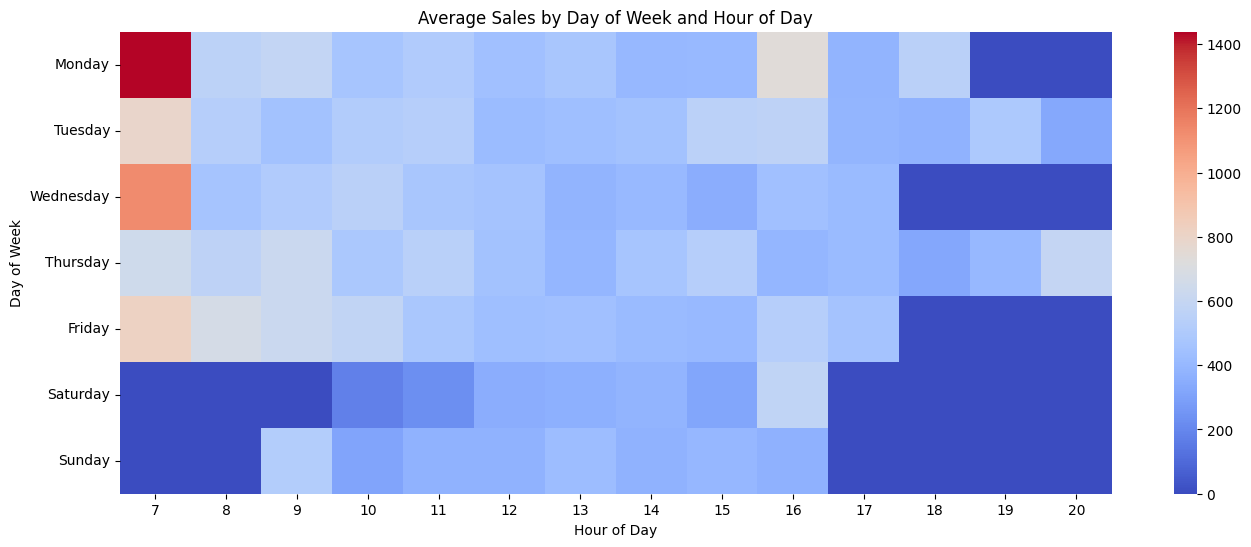

In [166]:
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Average Sales by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

## Features Engineering (v1.0)

### Last Purchase and Determining Churn

In [115]:
reference_date = df['InvoiceDate'].max()

last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
last_purchase['days_since_last_purchase'] = (reference_date - last_purchase['InvoiceDate']).dt.days
last_purchase['Churned'] = last_purchase['days_since_last_purchase'] > 180

### Churned vs Active Customers Analysis

In [116]:
customer_metrics = df.groupby('Customer ID').agg(
    total_revenue=('TotalSales', 'sum'),
    num_orders=('Invoice', 'nunique'),
    avg_order_value=('TotalSales', 'mean'),
    first_purchse=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
)
customer_metrics['tenure_days'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchse']).dt.days
customer_metrics = customer_metrics.merge(last_purchase[['Customer ID', 'days_since_last_purchase', 'Churned']], on='Customer ID')
customer_metrics

,Customer ID,total_revenue,num_orders,avg_order_value,first_purchse,last_purchase,tenure_days,days_since_last_purchase,Churned
0,12346,372.86,11,33.896364,2009-12-14 08:34:00,2010-06-28 13:53:00,196,164,False
1,12347,1323.32,2,661.660000,2010-10-31 14:20:00,2010-12-07 14:57:00,37,2,False
2,12348,222.16,1,222.160000,2010-09-27 14:59:00,2010-09-27 14:59:00,0,73,False
3,12349,2671.14,3,890.380000,2010-04-29 13:20:00,2010-10-28 08:23:00,181,42,False
4,12351,300.93,1,300.930000,2010-11-29 15:23:00,2010-11-29 15:23:00,0,10,False
...,...,...,...,...,...,...,...,...,...
4307,18283,619.37,6,103.228333,2010-02-19 17:16:00,2010-11-22 15:30:00,275,17,False
4308,18284,461.68,1,461.680000,2010-10-04 11:33:00,2010-10-04 11:33:00,0,66,False
4309,18285,427.00,1,427.000000,2010-02-17 10:24:00,2010-02-17 10:24:00,0,295,True
4310,18286,1296.43,2,648.215000,2009-12-16 10:45:00,2010-08-20 11:57:00,247,111,False


In [61]:
prediction_features = df.groupby('Customer ID').agg(
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max'),
    avg_days_between=('DaysBetween', 'mean'),
    purchase_frequency=('Invoice', 'nunique')
)
prediction_features['tenure_days'] = (prediction_features['last_purchase'] - prediction_features['first_purchase']).dt.days
prediction_features = prediction_features.merge(last_purchase[['Customer ID', 'Churned']], on='Customer ID')
prediction_features = prediction_features[prediction_features['first_purchase'] < '2010-06-30'].reset_index(drop=True)
prediction_features.drop(columns=['Customer ID', 'first_purchase'], inplace=True)
prediction_features


,last_purchase,avg_days_between,purchase_frequency,tenure_days,Churned
0,2010-06-28 13:53:00,19.200000,11,196,False
1,2010-10-28 08:23:00,90.000000,3,181,False
2,2010-05-21 11:59:00,NaN,1,0,True
3,2010-11-29 10:56:00,177.500000,3,356,False
4,2010-10-10 11:16:00,61.400000,6,308,False
...,...,...,...,...,...
2956,2010-05-11 10:49:00,NaN,1,0,True
2957,2010-11-22 15:30:00,54.600000,6,275,False
2958,2010-02-17 10:24:00,NaN,1,0,True
2959,2010-08-20 11:57:00,247.000000,2,247,False


In [62]:
prediction_features['Churned'].value_counts()

Churned
False    2136
True      825
Name: count, dtype: int64

### Data Sanity Check

In [63]:
# Check class balance
prediction_features['Churned'].value_counts(normalize=True)

Churned
False    0.721378
True     0.278622
Name: proportion, dtype: float64

In [64]:
# Check NaN patterns, NaNs only appear in avg_days_between when pruchase_frequency is 1
prediction_features[['avg_days_between', 'purchase_frequency', 'tenure_days']].isna().mean()
assert(prediction_features[prediction_features['avg_days_between'].isna() == True]['purchase_frequency']==1).all()

In [65]:
# Validate feature ranges
prediction_features.describe()

,last_purchase,avg_days_between,purchase_frequency,tenure_days
count,2961,2335.000000,2961.000000,2961.000000
mean,2010-08-22 08:02:54.934143744,78.340448,5.636272,184.794326
min,2009-12-01 09:55:00,0.000000,1.000000,0.000000
25%,2010-05-27 20:31:00,35.100000,2.000000,47.000000
50%,2010-10-08 14:44:00,59.400000,3.000000,204.000000
75%,2010-11-21 12:11:00,100.333333,6.000000,300.000000
max,2010-12-09 20:01:00,361.000000,205.000000,373.000000
std,NaN,64.450819,9.571023,129.552204


### Visualization of Features

In [66]:
prediction_features.groupby('Churned')[['avg_days_between', 'purchase_frequency', 'tenure_days']].median()

,avg_days_between,purchase_frequency,tenure_days
Churned,,,
False,61.200000,5.0,255.0
True,41.666667,1.0,0.0


### Handling NaN before Modeling

In [67]:
prediction_features['avg_days_between'] = prediction_features['avg_days_between'].fillna(999)

### Building Predictive Model

In [68]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(prediction_features, test_size=0.2, random_state=42, stratify=prediction_features['Churned'])

X_train = np.array(train_data)[:, 2:4]
y_train = np.array(train_data)[:, -1].astype(int)
X_test = np.array(test_data)[:, 2:4]
y_test = np.array(test_data)[:, -1].astype(int)

In [69]:
X_train

array([[8, 135],
       [4, 281],
       [11, 358],
       ...,
       [1, 0],
       [5, 241],
       [5, 313]], shape=(2368, 2), dtype=object)

In [70]:
train_data['Churned'].value_counts(normalize=True), test_data['Churned'].value_counts(normalize=True)

(Churned
 False    0.721284
 True     0.278716
 Name: proportion, dtype: float64,
 Churned
 False    0.721754
 True     0.278246
 Name: proportion, dtype: float64)

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)
train_accuracy, test_accuracy

(0.918918918918919, 0.9409780775716695)

### Plotting the Data and the Logistic Line

In [73]:
model.intercept_[0], model.coef_[0][0], model.coef_[0][1]

(np.float64(-2.8020968579849534),
 np.float64(0.08460774737063391),
 np.float64(-3.610238782691847))

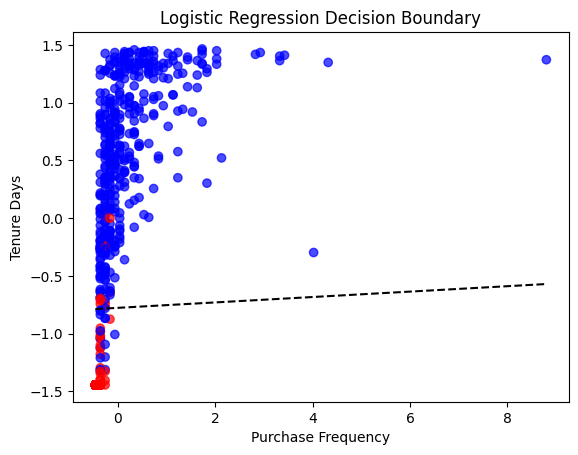

In [74]:
w1, w2 = model.coef_[0]
b = model.intercept_[0]

x_vales = np.linspace(X_test_scaled[:,0].min(), X_test_scaled[:,0].max(), 100)
y_values = -(w1 * x_vales + b) / w2

plt.scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, cmap='bwr', alpha=0.7)
plt.plot(x_vales, y_values, color='black', linestyle='--')
plt.xlabel('Purchase Frequency')
plt.ylabel('Tenure Days')
plt.title('Logistic Regression Decision Boundary')
plt.show()

## Features Engineering (v2.0)

In [255]:
T0 = pd.Timestamp('2010-06-11')
churn_window = 180

df_pre = df[df['InvoiceDate'] < T0]
features = df_pre.groupby('Customer ID').agg(
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
)
features['tenure_days'] = (T0 - features['first_purchase']).dt.days
features['recency'] = (T0 - features['last_purchase']).dt.days

df_post = df[df['InvoiceDate'] >= T0]
future_purchase = (df_post.groupby('Customer ID')['InvoiceDate'].min().reset_index(name='next_purchase'))

features = features.merge(future_purchase, on='Customer ID', how='left')
features['Churned'] = features['next_purchase'].isna() | ((features['next_purchase'] - T0).dt.days > churn_window)

features.drop(columns=['Customer ID', 'first_purchase', 'last_purchase', 'next_purchase'], inplace=True)
features

,tenure_days,recency,Churned
0,178,100,False
1,42,23,False
2,20,20,True
3,184,3,False
4,187,79,False
...,...,...,...
2798,30,30,True
2799,111,74,False
2800,113,113,True
2801,176,176,False


### Data Sanity Check

In [256]:
# Check class balance
features['Churned'].value_counts(normalize=True)

Churned
False    0.70817
True     0.29183
Name: proportion, dtype: float64

In [257]:
# Validate feature ranges
features.describe()

,tenure_days,recency
count,2803.000000,2803.000000
mean,119.259008,62.493043
std,58.779570,53.809451
min,0.000000,0.000000
25%,73.000000,18.000000
50%,126.000000,46.000000
75%,181.000000,95.000000
max,191.000000,191.000000


### Visualization of Features

In [258]:
features.groupby('Churned')[['tenure_days', 'recency']].median()

,tenure_days,recency
Churned,,
False,134.0,37.0
True,107.5,76.0


## Predictive Model (Logistic Regression)

In [279]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42, stratify=features['Churned'])

X_train = np.array(train_data)[:, :2]
y_train = np.array(train_data)[:, -1].astype(int)
X_test = np.array(test_data)[:, :2]
y_test = np.array(test_data)[:, -1].astype(int)

In [280]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [281]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)
train_accuracy, test_accuracy

(0.7056199821587869, 0.7058823529411765)

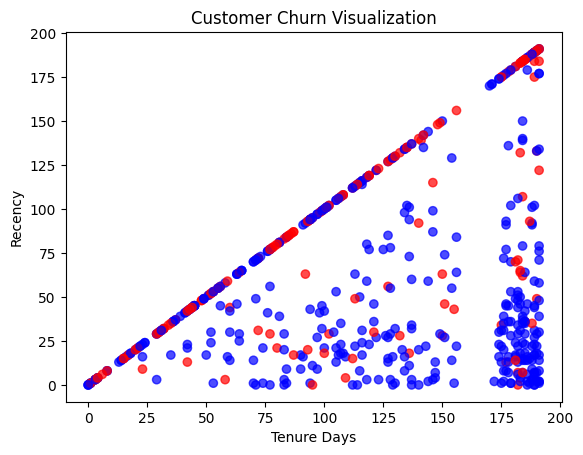

In [282]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr', alpha=0.7)
plt.xlabel('Tenure Days')
plt.ylabel('Recency')
plt.title('Customer Churn Visualization')
plt.show()

In [308]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.7152807642686

In [307]:
model.intercept_[0], model.coef_[0][0], model.coef_[0][1]

(np.float64(-1.088175540562722),
 np.float64(-0.7891250804548963),
 np.float64(0.8942428013490394))

Looking at the coefficients, we note that holding other variables constant, a one standard deviation increase in recency increases the odds of churn by 89.42%. Similarly, holding other variables constant, a one standard increase in tenure_days decreases the odds of churn by 78.91%.

## Predictive Model (Random Forest)

In [271]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42, stratify=features['Churned'])

X_train = np.array(train_data)[:, :2]
y_train = np.array(train_data)[:, -1].astype(int)
X_test = np.array(test_data)[:, :2]
y_test = np.array(test_data)[:, -1].astype(int)

In [272]:
from sklearn.ensemble import RandomForestClassifier
rd_model = RandomForestClassifier(n_estimators=100, max_depth=5, max_leaf_nodes=10, random_state=42)
rd_model.fit(X_train, y_train)
train_accuracy = rd_model.score(X_train, y_train)
test_accuracy = rd_model.score(X_test, y_test)
train_accuracy, test_accuracy

(0.7190008920606601, 0.696969696969697)

In [273]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.7152807642686

In [274]:
rd_model.feature_importances_

array([0.41668864, 0.58331136])

## Testing the Model with 2010-2011 data

In [126]:
df_2010 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
df_2010.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [127]:
# Data Cleaning for 2009-2010 Data
df = df_2010.copy()

# Remove rows with missing Customer ID or Description
df = df.dropna(subset=['Customer ID', 'Description'])

# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0 ) & (df['Price'] > 0)]
df['Invoice'] = df['Invoice'].astype(str)

# Remove canceled orders (Invoice starting with 'C')
df = df[~df['Invoice'].str.startswith('C')]

# Create Total Sales column
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove duplicate rows
df = df.drop_duplicates()

# Convert Customer ID to integer
df['Customer ID'] = df['Customer ID'].astype(int)

In [128]:
df = df.groupby(['Invoice', 'Customer ID', 'InvoiceDate', 'Country'], as_index=False).agg({'TotalSales': 'sum'})

In [129]:
T0 = pd.Timestamp('2011-06-11')
churn_window = 180

df_pre = df[df['InvoiceDate'] < T0]
features = df_pre.groupby('Customer ID').agg(
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
)
features['tenure_days'] = (T0 - features['first_purchase']).dt.days
features['recency'] = (T0 - features['last_purchase']).dt.days

df_post = df[df['InvoiceDate'] >= T0]
future_purchase = (df_post.groupby('Customer ID')['InvoiceDate'].min().reset_index(name='next_purchase'))

features = features.merge(future_purchase, on='Customer ID', how='left')
features['Churned'] = features['next_purchase'].isna() | ((features['next_purchase'] - T0).dt.days > churn_window)

features.drop(columns=['Customer ID', 'first_purchase', 'last_purchase', 'next_purchase'], inplace=True)
features

,tenure_days,recency,Churned
0,143,143,True
1,185,1,False
2,176,66,False
3,128,128,True
4,114,80,False
...,...,...,...
2806,64,43,False
2807,75,75,False
2808,95,95,True
2809,155,18,False


In [130]:
from sklearn.model_selection import train_test_split

X_test = np.array(features)[:, :2]
y_test = np.array(features)[:, -1].astype(int)

In [131]:
test_accuracy = model.score(X_test, y_test)
test_accuracy

0.6912130914265386

In [132]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.7216272614935401

## Predictive Model (Logistic Regression) Threshold Optimization

In [335]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

threshold = 0.3
y_prob = model.predict_proba(X_test)[:,1]
y_pred = (y_prob >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Confusion Matrix:\n{cm}')
print(f'Total: {cm.sum()} datapoints')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')

Confusion Matrix:
[[254 143]
 [ 46 118]]
Total: 561 datapoints
Accuracy: 66.31%
Precision: 45.21%
Recall: 71.95%
F1 Score: 55.53%


- Accuracy: How often is the model correct overall
- Precision: High precision -> fewer false alarms
- Recall: High recall -> fewer missed churns
- F1-Score: Balance false positives and false negatives

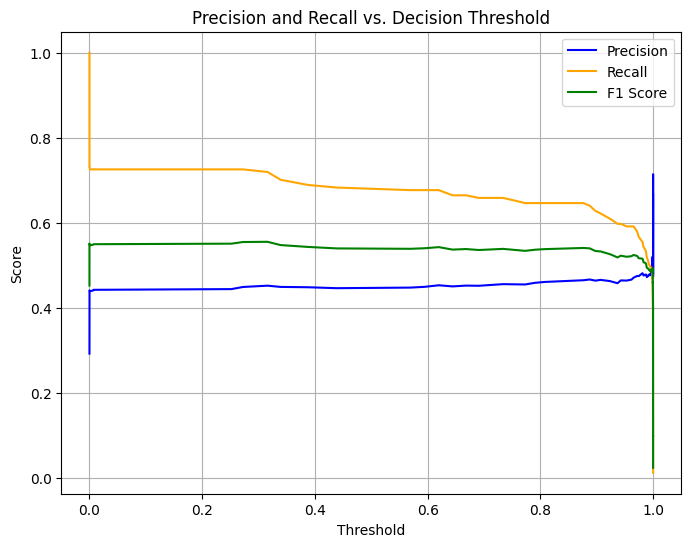

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [338]:
model.intercept_[0], model.coef_[0][0], model.coef_[0][1]

(np.float64(-1.088175540562722),
 np.float64(-0.7891250804548963),
 np.float64(0.8942428013490394))

## Business Report

### Insights
The model correctly identifies ~72% of customers who will churn (high recall). Less than half of the predicted churners actually churn (precision 45%), meaning some resources might go to the custoemrs who wouldn't churn. 

### Steps to take:
- Focus retention efforts on customers with short tenure or long recency. For example, someone who hasn't pucharsed in 100+ days buy has only been a customer for a few months is high risk.
- Create targeted campaigns for high-risk segments: discounts, personlized offers, reminders.
- Engage with recently inactive customers through emails or app notifications.

## Ranking Customers by Churn Probability